# First of all, let's import libraries that we want to use

In [113]:
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import glob
# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Reading and Cleaning Data

### Reading the File
We have to itarate over all the files, and parse them into a single dataframe, called data_raw. The columns in chinese, which I guess is the city name.

In [114]:
path = "data/**/*.csv"
all_files = glob.glob(path)

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, encoding="utf-8")
    li.append(df)

data_raw = pd.concat(li, axis=0, ignore_index=True)
# data_raw.info()

data = data_raw.copy()

### Dealing with the chinese city names
Since I cannot work with the chinese names, I decided to change their names, to something like city1, city2, etc.

In [115]:
columns = ['date', 'hour', 'type']
for i in range(1, 36):
    columns.append("City" + str(i))

data = data.set_axis(columns, axis='columns')

cityIndex = 6
city = "City" + str(cityIndex)

### Concatenating date and hour

I would like to convert the data into a timestamp, which also includes the hour data. To do so, I will append the hour data to the date, and convert it.

In [116]:
data['timestamp'] = pd.to_datetime(data['date'].astype(str) + 'T' + data['hour'].astype(str) + ":00:00", format='%Y%m%dT%H:%M:%S')
data = data.drop(columns='date')
data = data.drop(columns='hour')

### Setting the index to timestamp, and sort the data. 

I realized the are duplicates with the timestamps, so had to get rid of them to be able to sort it with 1 hour frequency.

In [117]:
data = data.set_index('timestamp')
data = data.loc[~data.index.duplicated(), :]
data = data.asfreq('1h')
data = data.sort_index()

### Here I would like to only look into data with specified type as PM2.5

In [118]:
pollution_type = "PM2.5"

data_pm2p5 = data.loc[data['type'] == "PM2.5"]
data_pm2p5 = data_pm2p5.asfreq('1h')
data_pm2p5 = data_pm2p5.sort_index()

Let's do smoothing

## Fixing missing data
looking into the `data_pm2p5.info()`, I can see missing data for each city. We somehow have to fill those numbers. There are many ways to do it. Like taking the mean, median or (max, min). Also, we can be more advanced and do linear regressions. For now, Let's replace all missing data with mean variable.

In [119]:
data_pm2p5[city]=data_pm2p5[city].fillna(data_pm2p5[city].mean())

### index check
We need to make sure the index is complete

In [120]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                              end=data.index.max(),
                              freq=data.index.freq)).all()
# Fill gaps if something is wrong (if previous statement returns false)
# ==============================================================================
# data.asfreq(freq='30min', fill_value=np.nan)

True

# Splitting data into train, validation, and test set

### How I decided splitting the data
I will consider all data for 2014, 2015 for training.
Further will consider data for 2016 for validation.
Finally consider remaining data for 2017 for test.

I keep the anual data in a set, since I would like to have a chance to capture seasonality in the data

In [121]:
data_pm2p5 = data_pm2p5.loc['2014-01-01 00:00:00': '2017-04-29 23:00:00']
end_train = '2015-12-31 23:00:00'
end_validation = '2016-12-28 23:00:00'
data_train = data_pm2p5.loc[: end_train, :]
data_val   = data_pm2p5.loc[end_train:end_validation, :]
data_test  = data_pm2p5.loc[end_validation:, :]

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}")

Train dates      : 2014-01-01 00:00:00 --- 2015-12-31 23:00:00
Validation dates : 2015-12-31 23:00:00 --- 2016-12-28 23:00:00
Test dates       : 2016-12-28 23:00:00 --- 2017-04-29 23:00:00


# Plotting

It's time to do some plotting and see what's going on in the data. At this point, I would like to only consider the City1 prediction. Maybe further I go and do the same for other cities.

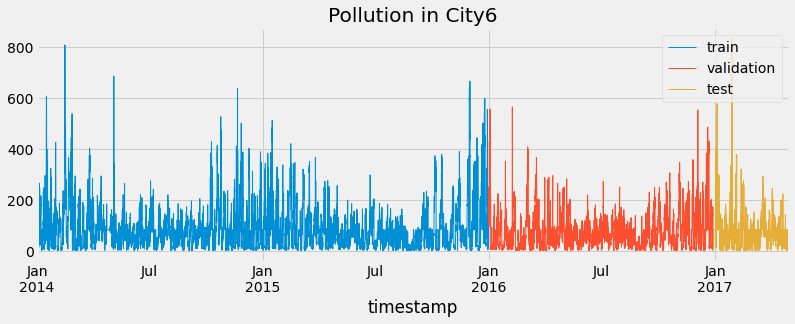

In [122]:
fig, ax = plt.subplots(figsize=(12, 4))
data_train.City6.plot(ax=ax, label='train', linewidth=1)
data_val.City6.plot(ax=ax, label='validation', linewidth=1)
data_test.City6.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Pollution in ' + city)
ax.legend();

This is the whole data, but it's so crowded. I can see some patterns here. For example, early in the year the pollution is high. Looks like the pollution is low during the summer, which kinda makes sense. Generally, pollution is higher when it's cold.

## Monthly pattern

Let's take a look into some months and see how is the data

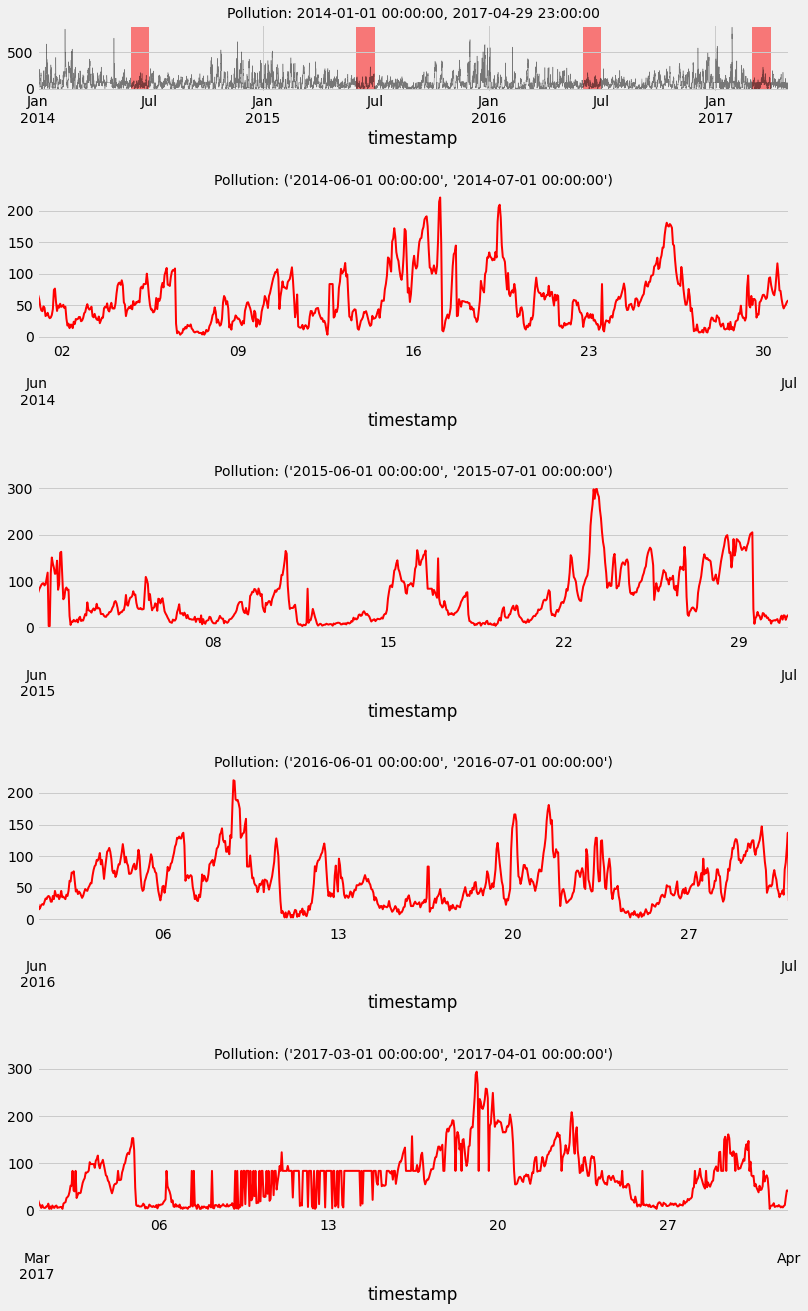

In [123]:
month1 = ('2014-06-01 00:00:00','2014-07-01 00:00:00')
month2 = ('2015-06-01 00:00:00','2015-07-01 00:00:00')
month3 = ('2016-06-01 00:00:00','2016-07-01 00:00:00')
month4 = ('2017-03-01 00:00:00','2017-04-01 00:00:00')

fig = plt.figure(figsize=(12, 24))
grid = plt.GridSpec(nrows=34, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
month1_ax = fig.add_subplot(grid[5:9, :])
month2_ax = fig.add_subplot(grid[12:16, :])
month3_ax = fig.add_subplot(grid[19:23, :])
month4_ax = fig.add_subplot(grid[26:30, :])

data_pm2p5[city].plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data_pm2p5.City6)
max_y = max(data_pm2p5.City6)

main_ax.fill_between(month1, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month2, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month3, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month4, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)

# main_ax.set_xlabel('')

data_pm2p5.loc[month1[0]: month1[1]][city].plot(ax=month1_ax, color='red', linewidth=2)
data_pm2p5.loc[month2[0]: month2[1]][city].plot(ax=month2_ax, color='red', linewidth=2)
data_pm2p5.loc[month3[0]: month3[1]][city].plot(ax=month3_ax, color='red', linewidth=2)
data_pm2p5.loc[month4[0]: month4[1]][city].plot(ax=month4_ax, color='red', linewidth=2)

main_ax.set_title(f'Pollution: {data_pm2p5.index.min()}, {data_pm2p5.index.max()}', fontsize=14)
month1_ax.set_title(f'Pollution: {month1}', fontsize=14)
month2_ax.set_title(f'Pollution: {month2}', fontsize=14)
month3_ax.set_title(f'Pollution: {month3}', fontsize=14)
month4_ax.set_title(f'Pollution: {month4}', fontsize=14)
plt.subplots_adjust(hspace=1)

So right now, I can't see much going on, at least visually. When I looked online, I have seen people using boxplots and things like that to see what's going on. Now let me draw box plots for observing seasonality anually, monthly, and weekly. Maybe we are going to observe something here. Hopefully!

## Box plot for annual seasonality

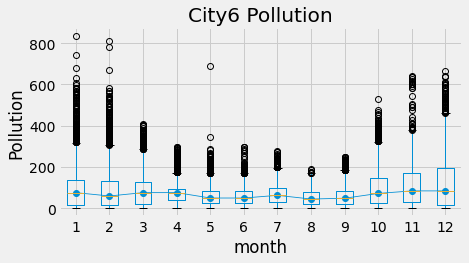

In [124]:
fig, ax = plt.subplots(figsize=(7, 3.5))
data_pm2p5['month'] = data_pm2p5.index.month
data_pm2p5.boxplot(column=city, by='month', ax=ax,)
data_pm2p5.groupby('month')[city].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Pollution')
ax.set_title(city + ' Pollution')
fig.suptitle('');

## Box plot for weekly seasonality

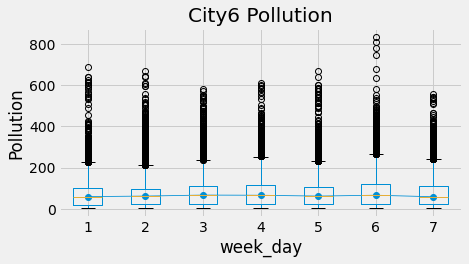

In [125]:
fig, ax = plt.subplots(figsize=(7, 3.5))
data_pm2p5['week_day'] = data_pm2p5.index.day_of_week + 1
data_pm2p5.boxplot(column=city, by='week_day', ax=ax)
data_pm2p5.groupby('week_day')[city].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Pollution')
ax.set_title(city + ' Pollution')
fig.suptitle('');

## Box plot for daily seasonality

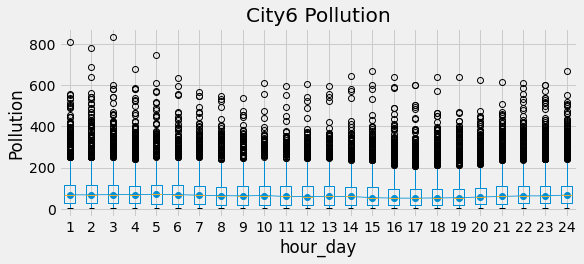

In [126]:

fig, ax = plt.subplots(figsize=(9, 3.5))
data_pm2p5['hour_day'] = data_pm2p5.index.hour + 1
data_pm2p5.boxplot(column=city, by='hour_day', ax=ax)
data_pm2p5.groupby('hour_day')[city].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Pollution')
ax.set_title(city + ' Pollution')
fig.suptitle('');

## Some minor analysis
Things are getting a bit interesting. Looking at the plots above, I can see a similar median for the box plots, but a lot of high variance, and data that are above 75% percentile. That means, they almost embody the same mean (or median?), which is not visible through the pattern plots we did above. I realized there is some kind of plot, called violin plot, which shows the distribution and concentration of the data for a specific period. I would like to do that month months, and days of the week. That would help us to see if our data is skewed. In other words, we can see if the data is all over the place, which is something that I really don't like :D

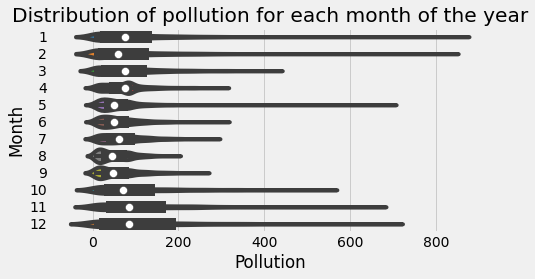

In [127]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = city,
    y       = 'Month',
    data    = data_pm2p5.assign(Month = data_pm2p5.index.month.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribution of pollution for each month of the year')
ax.set_xlabel('Pollution')
ax.set_ylabel('Month');

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'City6',
    y       = 'week_day',
    data    = data_pm2p5.assign(week_day = data_pm2p5.index.day_of_week.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribution of pollution for each day of the week')
ax.set_xlabel('Pollution')
ax.set_ylabel('Day of Week');

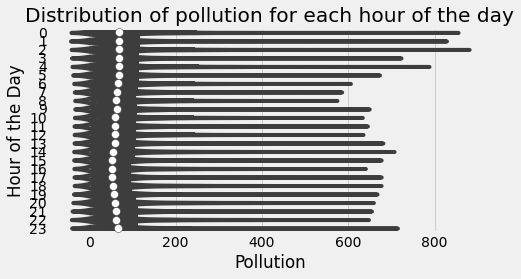

In [128]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = city,
    y       = 'hour',
    data    = data_pm2p5.assign(hour = data_pm2p5.index.hour.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribution of pollution for each hour of the day')
ax.set_xlabel('Pollution')
ax.set_ylabel('Hour of the Day');

## Analysis again 

Ok, we got all the data above. There are multiple things need to be done:
- We need to figure out whether we see seasonality or trend in the dataset. Proof of this observation can highly affect the methods we choose to perform data transformations.
- Based on the previous observations, we can choose what kind of model to use. 

### Is data stationary or not?
We need to figure out if the data is stationary or not. Stationarity is the property of exhibiting constant statistical properties (mean, variance, autocorrelation, etc.). Usually the most important factor is the mean. If we look into the above box plots, we can observe stationary mean values, but the variance is high. So, while I believe the data is stationary, I'm still not really confident. So, I thought, why not check for stationarity through some well-known method. One such method is Dickey-Fuller test. Here is the test:

In [129]:
data_pm2p5[city]=data_pm2p5[city].fillna(data_pm2p5[city].mean())
result = adfuller(data_pm2p5[city])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -17.558571
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Based on the explanation, an ADF value below 1% or 5% shows that the data stationary, which is our case. As a result, I assume our data is stationary and we don't need to do any `difference` method on the data. 

### Choosing the method
Based on the above information, I would like to go with a simple method of regression. I don't think we need really complicated models like ARIMA or LSTM. I guess for the sake of this homework, I'll go with linear regression, which should work pretty well with stationary data.

## Since I wanna use autoregressive from skforecast



When reading online, I realized there are two metrics that are good indications of whether autoregressive works or not. There two metrics are autocorrelation and partial autocorrelation. To be honest, I may not know in depth how these work. But, let's take my aim and see how does it work on my data. Basically, it reveleas whether there is an association between one data point, and another data point with a specific interval. For example, you wanna know if the data in this hour has association with the data of the previous hour.

I'm not really sure if this gonna help or not, but as something people using online, it may help us too.

## Autocorrelation and Partial Autocorrelation

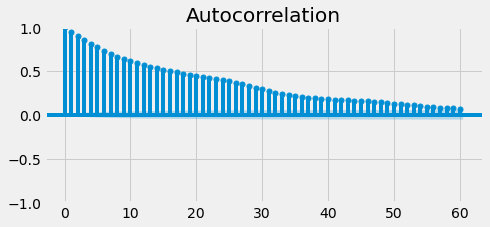

In [130]:
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(data_pm2p5[city], ax=ax, lags=60)
plt.show()

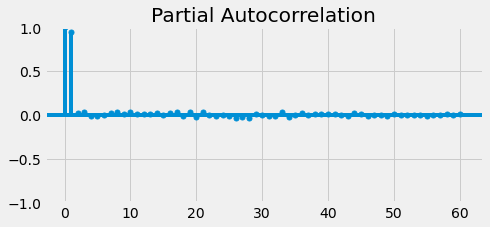

In [131]:
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(data_pm2p5[city], ax=ax, lags=60)
plt.show()

Let's also do the lag plot.

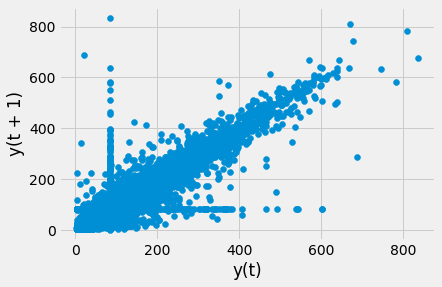

In [132]:
lag_plot(data_pm2p5[city])
pyplot.show()

This plot is really promising. You can see all data are around the diagonal straight line. I'm happy now :D

## Now what?
Honestly, I don't know what to look for at this stage. To me, the pattern is not completely clear for me. So, I guess I will just move on to the fitting process and see what will happen. 

For this specific problem, I feel like I can go down with linear regression, which is a simple pattern matching model, but rather effective in many situations. Using the `skforecast` library, I can rely on `ForecasterAutoreg` function. This is trained from a linear regression model, by providing it what penalty function to use, and what window of previous data (`lag`) to use to train the model.

## Training

In [133]:
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 24
             )

forecaster.fit(y=data_pm2p5.loc[:end_validation, 'City6'])
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2016-12-28 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-02-13 21:26:20 
Last fit date: 2022-02-13 21:26:20 
Skforecast version: 0.4.2 

## Backtesting

This is something I have never heard before, and just learned recently. Looks like a lot of people are performing backtesting (https://joaquinamatrodrigo.github.io/skforecast/0.4.1/guides/backtesting.html), after the training. So this is how it works. If you look above, our training dataset index start from `2014-01-01 00:00:00` to `2015-12-31 23:00:00`. As they mention in the document above, `it is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set is increased sequentially, maintaining the temporal order of the data`. Need to mention, we are trying the version, where `refit` is off, just to make sure the upcoming window of data does not change the model parameters. The `backtest` function in `skforecast` returns the error after it's done.

Another thing, we set the steps as 24, because we want to do the fitting based 24 hours window of a day.

In [134]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data_pm2p5[city],
                            initial_train_size = len(data_pm2p5.loc[:end_validation]),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit = False,
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 26232
Number of observations used for backtesting: 2928
    Number of folds: 122
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2016-12-29 00:00:00 -- 2016-12-29 23:00:00
Data partition in fold: 1
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2016-12-30 00:00:00 -- 2016-12-30 23:00:00
Data partition in fold: 2
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2016-12-31 00:00:00 -- 2016-12-31 23:00:00
Data partition in fold: 3
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2017-01-01 00:00:00 -- 2017-01-01 23:00:00
Data partition in fold: 4
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2017-01-02 00:00:00 -- 2017-01-02 23:00:00
Data partition in fold: 

## Judgement Day

Ok, I know this may not look really good, but I have to show the fitted function. Possibly the accuracy will suck, but what else I can do?

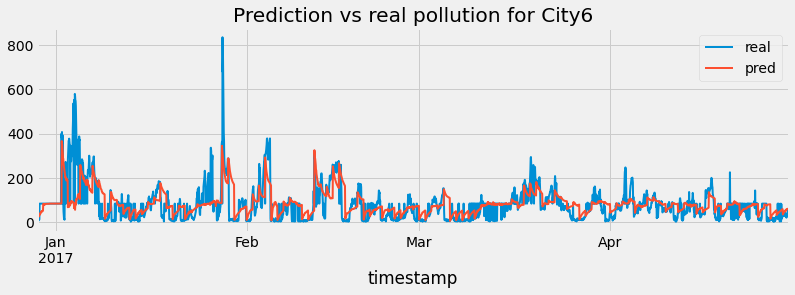

In [135]:
fig, ax = plt.subplots(figsize=(12, 3.5))
data_pm2p5.loc[predictions.index, city].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real pollution for City6')
ax.legend();

We have some idea here, but let me zoom into it a little bit.

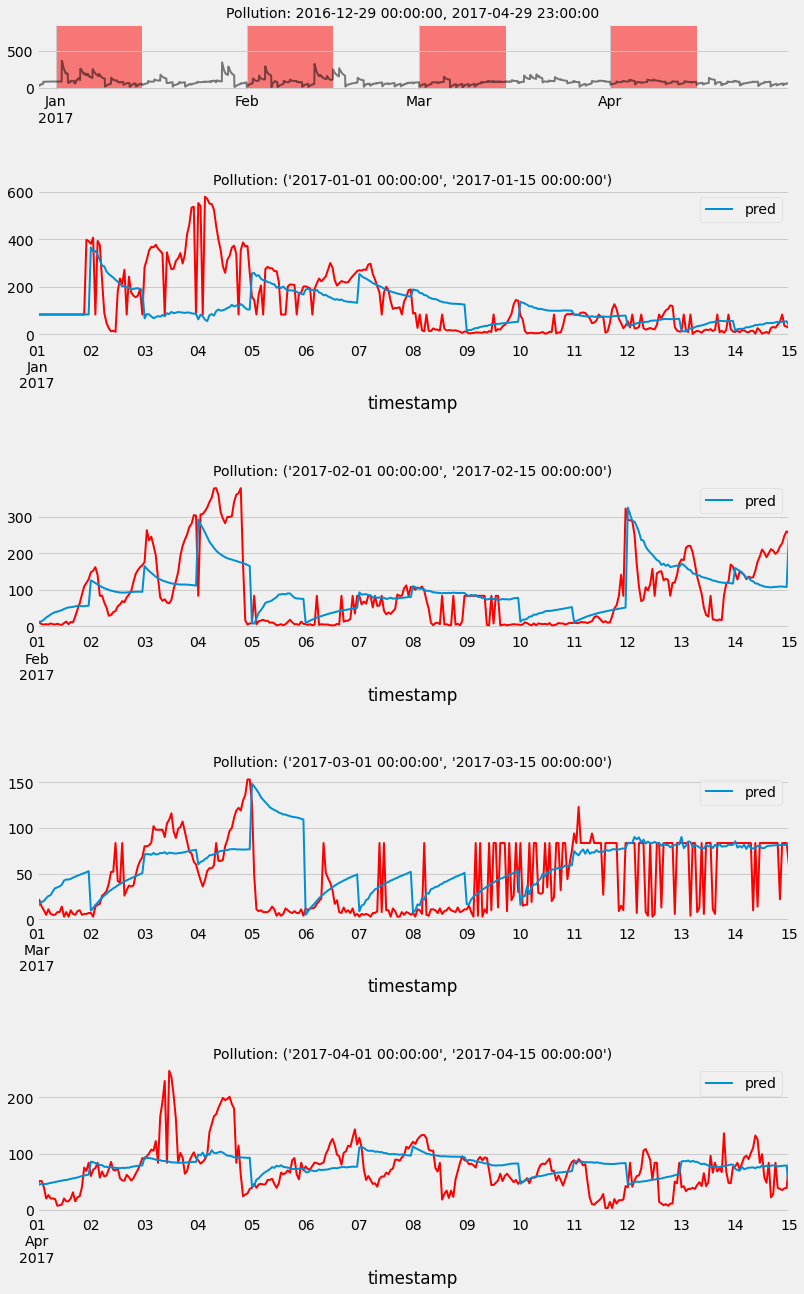

In [136]:
month1 = ('2017-01-01 00:00:00','2017-01-15 00:00:00')
month2 = ('2017-02-01 00:00:00','2017-02-15 00:00:00')
month3 = ('2017-03-01 00:00:00','2017-03-15 00:00:00')
month4 = ('2017-04-01 00:00:00','2017-04-15 00:00:00')

fig = plt.figure(figsize=(12, 24))
grid = plt.GridSpec(nrows=34, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
month1_ax = fig.add_subplot(grid[5:9, :])
month2_ax = fig.add_subplot(grid[12:16, :])
month3_ax = fig.add_subplot(grid[19:23, :])
month4_ax = fig.add_subplot(grid[26:30, :])

predictions.pred.plot(ax=main_ax, c='black', alpha=0.5, linewidth=2)
min_y = min(data_pm2p5[city])
max_y = max(data_pm2p5[city])

main_ax.fill_between(month1, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month2, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month3, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month4, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)

# main_ax.set_xlabel('')

data_pm2p5.loc[month1[0]:month1[1]][city].plot(ax=month1_ax, color='red', linewidth=2)
predictions.loc[month1[0]:month1[1]].plot(linewidth=2, label='prediction', ax=month1_ax)
data_pm2p5.loc[month2[0]:month2[1]][city].plot(ax=month2_ax, color='red', linewidth=2)
predictions.loc[month2[0]:month2[1]].plot(linewidth=2, label='prediction', ax=month2_ax)
data_pm2p5.loc[month3[0]:month3[1]][city].plot(ax=month3_ax, color='red', linewidth=2)
predictions.loc[month3[0]:month3[1]].plot(linewidth=2, label='prediction', ax=month3_ax)
data_pm2p5.loc[month4[0]:month4[1]][city].plot(ax=month4_ax, color='red', linewidth=2)
predictions.loc[month4[0]:month4[1]].plot(linewidth=2, label='prediction', ax=month4_ax)

main_ax.set_title(f'Pollution: {predictions.index.min()}, {predictions.index.max()}', fontsize=14)
month1_ax.set_title(f'Pollution: {month1}', fontsize=14)
month2_ax.set_title(f'Pollution: {month2}', fontsize=14)
month3_ax.set_title(f'Pollution: {month3}', fontsize=14)
month4_ax.set_title(f'Pollution: {month4}', fontsize=14)
plt.subplots_adjust(hspace=1)

And here is the error:

In [137]:
print(f'Backtest error: {metric}')

Backtest error: [43.06775462]


## How I'm gonna tune it?
So I thought about this, and realized the first step is to play with the penalty functions, and also the lag variable, which I set to 24 initially. Maybe I should think a different lag size to better fit the prediction function.

So, one option is to play with those parameters manually, which is insance. I don't really want to keep tuning my parameters and observe the error value. One really good approach is to have a system wich automatically tries all different options and pick the one that best serves the testing error. 

To do so, skforecast provides a function called `grid_search_forecaster`. This is like a loop, where tell the loop what range of parameters to look for, and it will go and iterate over all of them.

For the penalty function, I just pick something that I saw online and it's `param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}`. I honestly don't know now how it's been selected, but I can do it later if required by the interviewer. For the lags, I will go with different values, which include one day (plus and minus one hour), and also 1 or 2 day more than that.

In [138]:
forecaster = ForecasterAutoreg(
                    regressor = make_pipeline(StandardScaler(), Ridge()),
                    lags      = 24 # This value will be replaced in the grid search
              )

# Regressor's hyperparameters
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73, 7 * 24 - 1, 7 * 24, 7 * 24 + 1, 30 * 24 -1, 30 * 24, 30 * 24 + 1]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_pm2p5.loc[:end_validation, city],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(data_pm2p5[:end_train]),
                        return_best = True,
                        verbose     = False
                  )

Number of models compared: 30


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:48<00:00, 16.30s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'ridge__alpha': 0.001}
  Backtesting metric: 39.747177392918914



In [139]:
results_grid

lags  \
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
14  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
16  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
20  [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73, ...   
21  [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73, ...   
22  [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73, ...   
23  [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73, ...   
24  [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73, ...   
25  [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73, ...   
26  [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73, ...   
17  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
0                                     [1, 2, 3, 4, 5]   
1                                     [1, 2, 3, 4, 5]   
2                                     [1, 2, 3, 4, 5]   
3                                     [1, 2, 3, 4, 5]   
4                                     [1, 2, 3, 4, 5]   
5                                     [1, 2, 3, 4, 5]   
6                                     [1, 2, 3, 4, 5]   
27  [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73, ...   
7                                     [1, 2, 3, 4, 5]   
18  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
8                                     [1, 2, 3, 4, 5]   
28  [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73, ...   
19  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
29  [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73, ...   
9                                     [1, 2, 3, 4, 5]   

                                    params     metric   ridge__alpha  
10                 {'ridge__alpha': 0.001}  39.747177       0.001000  
11  {'ridge__alpha': 0.007742636826811269}  39.747183       0.007743  
12   {'ridge__alpha': 0.05994842503189409}  39.747230       0.059948  
13   {'ridge__alpha': 0.46415888336127775}  39.747593       0.464159  
14     {'ridge__alpha': 3.593813663804626}  39.750391       3.593814  
15    {'ridge__alpha': 27.825594022071257}  39.771971      27.825594  
16    {'ridge__alpha': 215.44346900318823}  39.923041     215.443469  
20                 {'ridge__alpha': 0.001}  40.104238       0.001000  
21  {'ridge__alpha': 0.007742636826811269}  40.104246       0.007743  
22   {'ridge__alpha': 0.05994842503189409}  40.104304       0.059948  
23   {'ridge__alpha': 0.46415888336127775}  40.104759       0.464159  
24     {'ridge__alpha': 3.593813663804626}  40.108278       3.593814  
25    {'ridge__alpha': 27.825594022071257}  40.134843      27.825594  
26    {'ridge__alpha': 215.44346900318823}  40.317467     215.443469  
17    {'ridge__alpha': 1668.1005372000557}  40.664179    1668.100537  
0                  {'ridge__alpha': 0.001}  40.922217       0.001000  
1   {'ridge__alpha': 0.007742636826811269}  40.922218       0.007743  
2    {'ridge__alpha': 0.05994842503189409}  40.922229       0.059948  
3    {'ridge__alpha': 0.46415888336127775}  40.922311       0.464159  
4      {'ridge__alpha': 3.593813663804626}  40.922958       3.593814  
5     {'ridge__alpha': 27.825594022071257}  40.928325      27.825594  
6     {'ridge__alpha': 215.44346900318823}  40.984904     215.443469  
27    {'ridge__alpha': 1668.1005372000557}  41.468495    1668.100537  
7     {'ridge__alpha': 1668.1005372000557}  41.590757    1668.100537  
18    {'ridge__alpha': 12915.496650148827}  42.807567   12915.496650  
8     {'ridge__alpha': 12915.496650148827}  45.888242   12915.496650  
28    {'ridge__alpha': 12915.496650148827}  46.785522   12915.496650  
19              {'ridge__alpha': 100000.0}  47.811536  100000.000000  
29              {'ridge__alpha': 100000.0}  53.961568  100000.000000  
9               {'ridge__alpha': 100000.0}  55.092748  100000.000000

As you can see, there best error metric comes with many of the lags configurations, and `ridge_alpha` of `0.001`. Honestly, the numbers are not really promising :(

Now let's do the same backtesting with the same data again, and see what will happen.

In [140]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data_pm2p5[city],
                            initial_train_size = len(data_pm2p5.loc[:end_validation]),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit = False,
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 26232
Number of observations used for backtesting: 2928
    Number of folds: 122
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2016-12-29 00:00:00 -- 2016-12-29 23:00:00
Data partition in fold: 1
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2016-12-30 00:00:00 -- 2016-12-30 23:00:00
Data partition in fold: 2
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2016-12-31 00:00:00 -- 2016-12-31 23:00:00
Data partition in fold: 3
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2017-01-01 00:00:00 -- 2017-01-01 23:00:00
Data partition in fold: 4
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2017-01-02 00:00:00 -- 2017-01-02 23:00:00
Data partition in fold: 

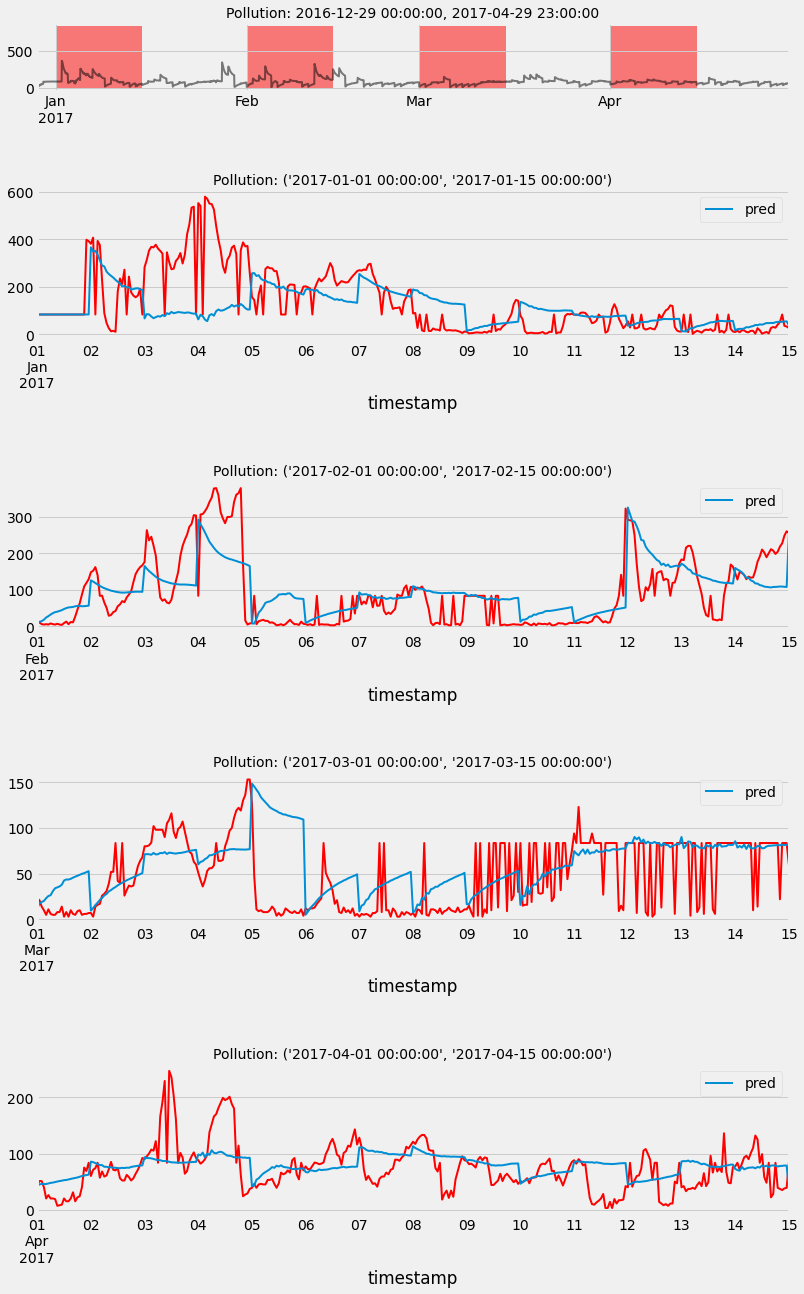

In [141]:
month1 = ('2017-01-01 00:00:00','2017-01-15 00:00:00')
month2 = ('2017-02-01 00:00:00','2017-02-15 00:00:00')
month3 = ('2017-03-01 00:00:00','2017-03-15 00:00:00')
month4 = ('2017-04-01 00:00:00','2017-04-15 00:00:00')

fig = plt.figure(figsize=(12, 24))
grid = plt.GridSpec(nrows=34, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
month1_ax = fig.add_subplot(grid[5:9, :])
month2_ax = fig.add_subplot(grid[12:16, :])
month3_ax = fig.add_subplot(grid[19:23, :])
month4_ax = fig.add_subplot(grid[26:30, :])

predictions.pred.plot(ax=main_ax, c='black', alpha=0.5, linewidth=2)
min_y = min(data_pm2p5[city])
max_y = max(data_pm2p5[city])

main_ax.fill_between(month1, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month2, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month3, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month4, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)

# main_ax.set_xlabel('')

data_pm2p5.loc[month1[0]:month1[1]][city].plot(ax=month1_ax, color='red', linewidth=2)
predictions.loc[month1[0]:month1[1]].plot(linewidth=2, label='prediction', ax=month1_ax)
data_pm2p5.loc[month2[0]:month2[1]][city].plot(ax=month2_ax, color='red', linewidth=2)
predictions.loc[month2[0]:month2[1]].plot(linewidth=2, label='prediction', ax=month2_ax)
data_pm2p5.loc[month3[0]:month3[1]][city].plot(ax=month3_ax, color='red', linewidth=2)
predictions.loc[month3[0]:month3[1]].plot(linewidth=2, label='prediction', ax=month3_ax)
data_pm2p5.loc[month4[0]:month4[1]][city].plot(ax=month4_ax, color='red', linewidth=2)
predictions.loc[month4[0]:month4[1]].plot(linewidth=2, label='prediction', ax=month4_ax)

main_ax.set_title(f'Pollution: {predictions.index.min()}, {predictions.index.max()}', fontsize=14)
month1_ax.set_title(f'Pollution: {month1}', fontsize=14)
month2_ax.set_title(f'Pollution: {month2}', fontsize=14)
month3_ax.set_title(f'Pollution: {month3}', fontsize=14)
month4_ax.set_title(f'Pollution: {month4}', fontsize=14)
plt.subplots_adjust(hspace=1)

## Data Smoothing
As a last resort, I wanted to apply data smoothing and just observe the fitted function compared to the original data. 

In [150]:
fit1 = SimpleExpSmoothing(data_pm2p5[city], initialization_method="heuristic").fit(
    smoothing_level=0.4, optimized=False
)

data_pm2p5_smooth = fit1.fittedvalues

#data_pm2p5_smooth = data_pm2p5_smooth.loc['2014-01-01 00:00:00': '2017-04-29 23:00:00']
end_train = '2015-12-31 23:00:00'
end_validation = '2016-12-28 23:00:00'
data_train = data_pm2p5_smooth.loc[:end_train]
data_val   = data_pm2p5_smooth.loc[end_train:end_validation]
data_test  = data_pm2p5_smooth.loc[end_validation:]

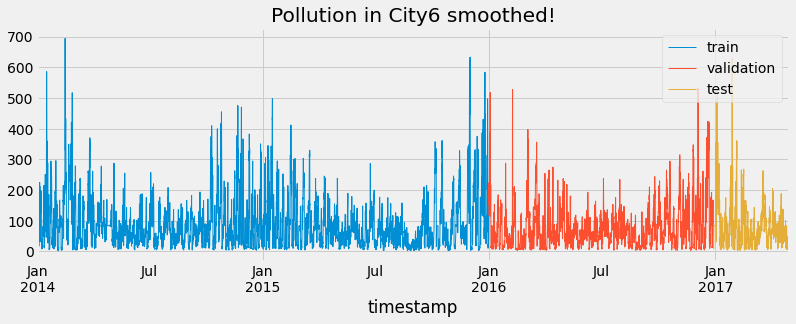

In [151]:
fig, ax = plt.subplots(figsize=(12, 4))
data_train.plot(ax=ax, label='train', linewidth=1)
data_val.plot(ax=ax, label='validation', linewidth=1)
data_test.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Pollution in ' + city + ' smoothed!')
ax.legend();

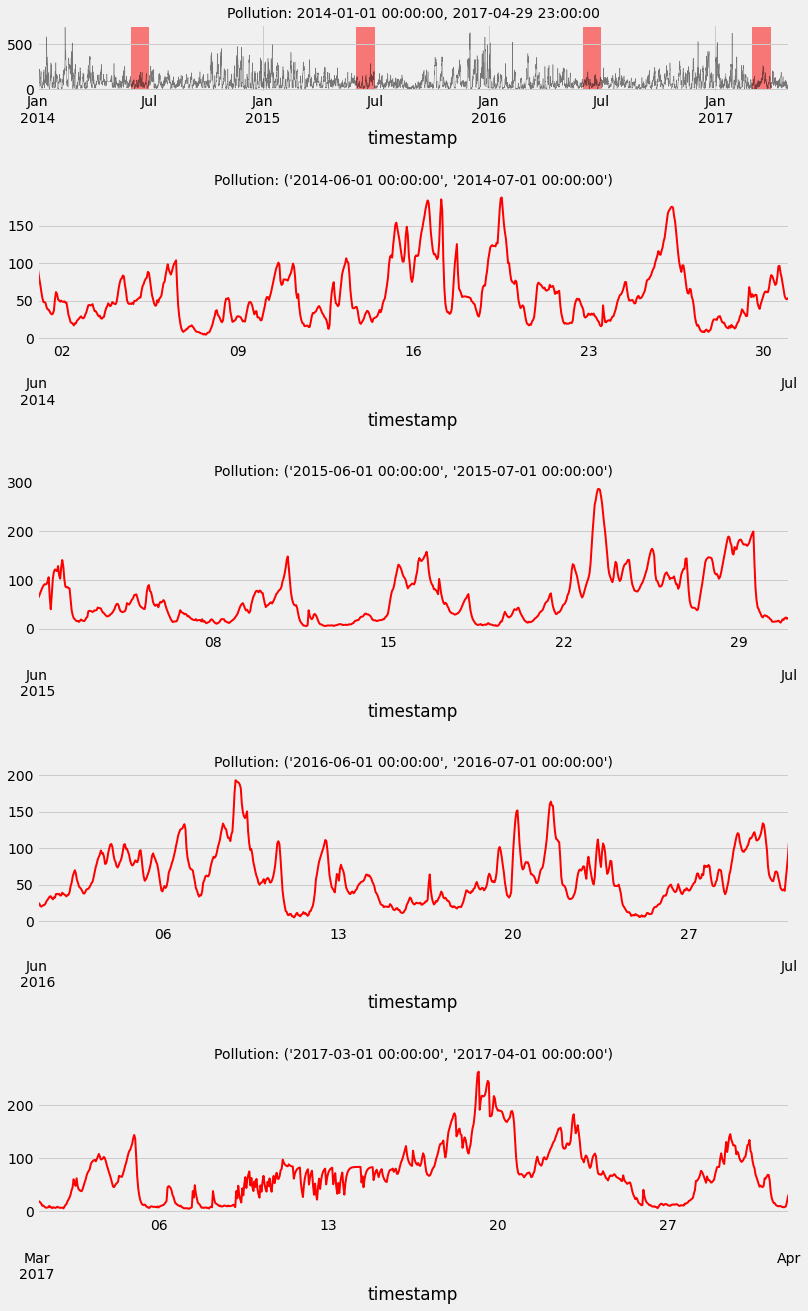

In [152]:
month1 = ('2014-06-01 00:00:00','2014-07-01 00:00:00')
month2 = ('2015-06-01 00:00:00','2015-07-01 00:00:00')
month3 = ('2016-06-01 00:00:00','2016-07-01 00:00:00')
month4 = ('2017-03-01 00:00:00','2017-04-01 00:00:00')

fig = plt.figure(figsize=(12, 24))
grid = plt.GridSpec(nrows=34, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
month1_ax = fig.add_subplot(grid[5:9, :])
month2_ax = fig.add_subplot(grid[12:16, :])
month3_ax = fig.add_subplot(grid[19:23, :])
month4_ax = fig.add_subplot(grid[26:30, :])

data_pm2p5_smooth.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data_pm2p5_smooth)
max_y = max(data_pm2p5_smooth)

main_ax.fill_between(month1, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month2, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month3, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month4, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)

# main_ax.set_xlabel('')

data_pm2p5_smooth.loc[month1[0]: month1[1]].plot(ax=month1_ax, color='red', linewidth=2)
data_pm2p5_smooth.loc[month2[0]: month2[1]].plot(ax=month2_ax, color='red', linewidth=2)
data_pm2p5_smooth.loc[month3[0]: month3[1]].plot(ax=month3_ax, color='red', linewidth=2)
data_pm2p5_smooth.loc[month4[0]: month4[1]].plot(ax=month4_ax, color='red', linewidth=2)

main_ax.set_title(f'Pollution: {data_pm2p5_smooth.index.min()}, {data_pm2p5_smooth.index.max()}', fontsize=14)
month1_ax.set_title(f'Pollution: {month1}', fontsize=14)
month2_ax.set_title(f'Pollution: {month2}', fontsize=14)
month3_ax.set_title(f'Pollution: {month3}', fontsize=14)
month4_ax.set_title(f'Pollution: {month4}', fontsize=14)
plt.subplots_adjust(hspace=1)

In [153]:
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 24
             )

forecaster.fit(y=data_pm2p5_smooth.loc[:end_validation])
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2016-12-28 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-02-13 21:28:35 
Last fit date: 2022-02-13 21:28:35 
Skforecast version: 0.4.2 

In [154]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data_pm2p5_smooth,
                            initial_train_size = len(data_pm2p5_smooth.loc[:end_validation]),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit = False,
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 26232
Number of observations used for backtesting: 2928
    Number of folds: 122
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2016-12-29 00:00:00 -- 2016-12-29 23:00:00
Data partition in fold: 1
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2016-12-30 00:00:00 -- 2016-12-30 23:00:00
Data partition in fold: 2
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2016-12-31 00:00:00 -- 2016-12-31 23:00:00
Data partition in fold: 3
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2017-01-01 00:00:00 -- 2017-01-01 23:00:00
Data partition in fold: 4
    Training:   2014-01-01 00:00:00 -- 2016-12-28 23:00:00
    Validation: 2017-01-02 00:00:00 -- 2017-01-02 23:00:00
Data partition in fold: 

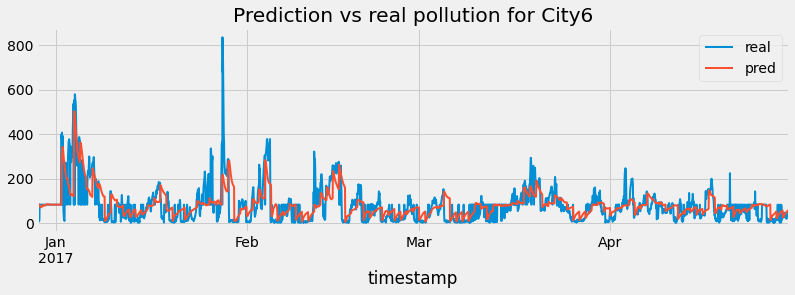

In [155]:
fig, ax = plt.subplots(figsize=(12, 3.5))
data_pm2p5.loc[predictions.index, city].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real pollution for City6')
ax.legend();

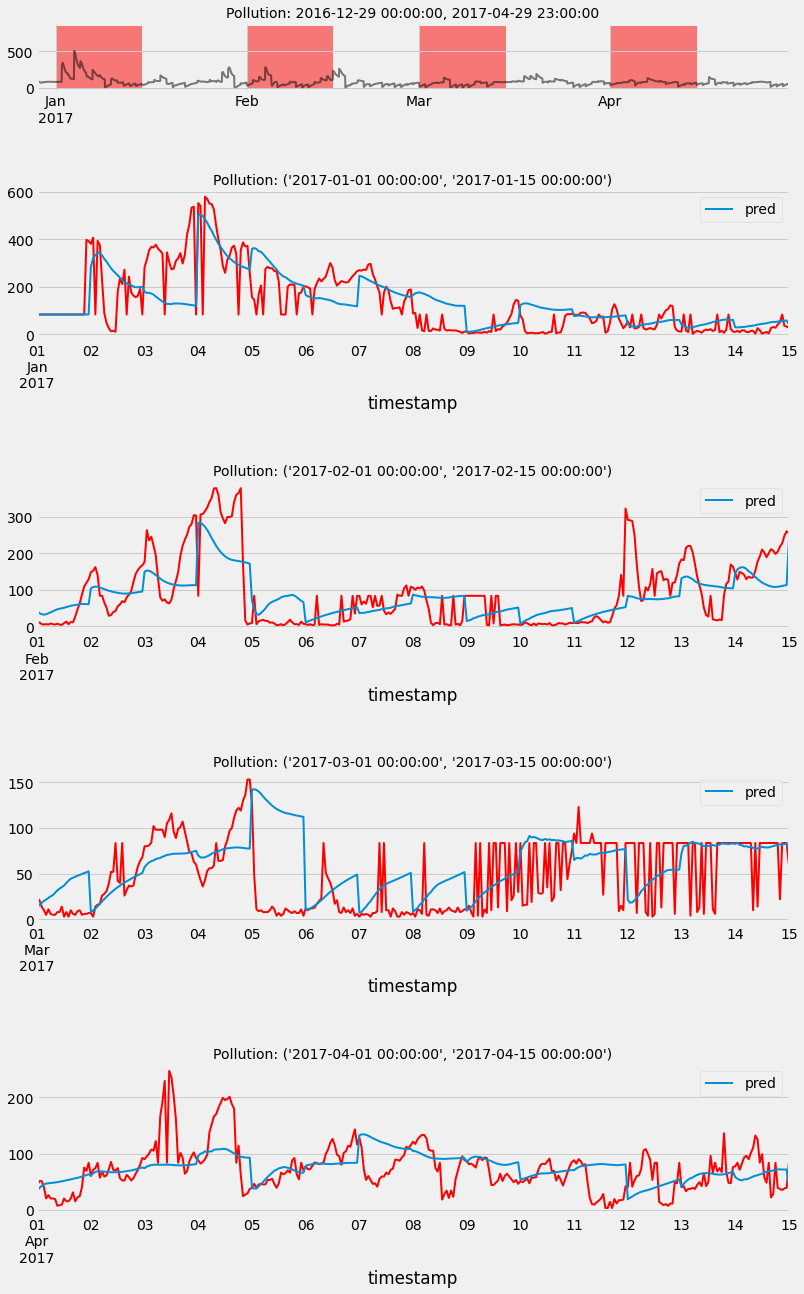

In [156]:
month1 = ('2017-01-01 00:00:00','2017-01-15 00:00:00')
month2 = ('2017-02-01 00:00:00','2017-02-15 00:00:00')
month3 = ('2017-03-01 00:00:00','2017-03-15 00:00:00')
month4 = ('2017-04-01 00:00:00','2017-04-15 00:00:00')

fig = plt.figure(figsize=(12, 24))
grid = plt.GridSpec(nrows=34, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
month1_ax = fig.add_subplot(grid[5:9, :])
month2_ax = fig.add_subplot(grid[12:16, :])
month3_ax = fig.add_subplot(grid[19:23, :])
month4_ax = fig.add_subplot(grid[26:30, :])

predictions.pred.plot(ax=main_ax, c='black', alpha=0.5, linewidth=2)
min_y = min(data_pm2p5[city])
max_y = max(data_pm2p5[city])

main_ax.fill_between(month1, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month2, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month3, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)
main_ax.fill_between(month4, min_y, max_y, facecolor='red', alpha=0.5, zorder=0)

# main_ax.set_xlabel('')

data_pm2p5.loc[month1[0]:month1[1]][city].plot(ax=month1_ax, color='red', linewidth=2)
predictions.loc[month1[0]:month1[1]].plot(linewidth=2, label='prediction', ax=month1_ax)
data_pm2p5.loc[month2[0]:month2[1]][city].plot(ax=month2_ax, color='red', linewidth=2)
predictions.loc[month2[0]:month2[1]].plot(linewidth=2, label='prediction', ax=month2_ax)
data_pm2p5.loc[month3[0]:month3[1]][city].plot(ax=month3_ax, color='red', linewidth=2)
predictions.loc[month3[0]:month3[1]].plot(linewidth=2, label='prediction', ax=month3_ax)
data_pm2p5.loc[month4[0]:month4[1]][city].plot(ax=month4_ax, color='red', linewidth=2)
predictions.loc[month4[0]:month4[1]].plot(linewidth=2, label='prediction', ax=month4_ax)

main_ax.set_title(f'Pollution: {predictions.index.min()}, {predictions.index.max()}', fontsize=14)
month1_ax.set_title(f'Pollution: {month1}', fontsize=14)
month2_ax.set_title(f'Pollution: {month2}', fontsize=14)
month3_ax.set_title(f'Pollution: {month3}', fontsize=14)
month4_ax.set_title(f'Pollution: {month4}', fontsize=14)
plt.subplots_adjust(hspace=1)